#  0. 문제정의
*  한국 시총 1위인 삼성전자 주식 선정(개별 종목 중 경제지수와 비슷하게 흘러가고, 찌라시에 덜 영향이 있을거라 생각)
*  삼성전자 종가와 VIX 지수관계 머신러닝으로 확인 
  -> VIX대신 USD/KRW로 잠시바꿈
*  삼성전자 LSTM으로 딥러닝 
*  window_size에 따른 마지막 케이스 셋에 대해서 종가의 오름 or 아님에 따라 매수 신호 또는 매도 신호 줄것. 
* text 파일로 해당 매수/매도 신호 정보 save, 특정 시간에 파일 read해서 신호에 따라 키움 api로 매수/매도 태워보기.

# 1. 데이터 수집

*  삼성전자 2010년 이후 데이터
*  VIX 2010년 이후 데이터 -> USD/KRW로 변경


In [2]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 9.2MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp36-cp36m-linux_x86_64.whl size=1437804 sha256=0b7ccf1fa450c1d5ef5ec2b6e017ac5099a06e83f3569d0c904318ab4c77238b
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [77]:
from pandas_datareader import data
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from keras.callbacks import EarlyStopping

import seaborn as sns; sns.set()

In [4]:
pip install -U finance-datareader

In [5]:
import FinanceDataReader as fdr

In [6]:
#samsung_st_date = '2010-12-16'
#samsung_enddate = '2020-12-16'
#samsung = data.DataReader('005930.ks', 'yahoo', samsung_st_date, samsung_enddate)
#samsung.head(9)

samsung = fdr.DataReader('005930', '2010') #2010년 이후 삼성 주가 가져옴


In [7]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516
2010-01-05,16520,16580,16300,16440,559219,0.016069
2010-01-06,16580,16820,16520,16820,459755,0.023114
2010-01-07,16820,16820,16260,16260,443237,-0.033294
2010-01-08,16400,16420,16120,16420,295798,0.009840
...,...,...,...,...,...,...
2020-12-17,73400,73700,72600,73300,24293214,-0.006775
2020-12-18,73300,73700,73000,73000,17613029,-0.004093
2020-12-21,73100,73400,72000,73000,20367355,0.000000


In [8]:
samsung.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

In [24]:
VIX = fdr.DataReader('USD/KRW', '2010') #2010년 이후 VIX 지수가져옴 -> 갑자기안돼서 USD/KRW로 변경
#VIX = fdr.DataReader('VIXCLS', start='2010', data_source='fred')
VIX


,Close,Open,High,Low,Change
Date,,,,,
2010-01-01,1166.08,1166.08,1166.08,1166.08,0.0000
2010-01-04,1150.00,1164.07,1164.07,1149.35,-0.0138
2010-01-05,1140.20,1151.00,1151.00,1136.30,-0.0085
2010-01-06,1129.20,1140.20,1144.70,1129.20,-0.0096
2010-01-07,1138.20,1129.20,1138.20,1127.80,0.0080
...,...,...,...,...,...
2020-12-17,1093.01,1094.12,1095.43,1090.27,0.0006
2020-12-18,1099.39,1094.01,1100.78,1092.34,0.0058
2020-12-21,1102.55,1099.48,1112.74,1097.94,0.0029


## 데이터 시각화

* 삼전종가
* VIX종가
* 삼전 이동평균선
* 삼전과 vix의 관계 그래프 등등

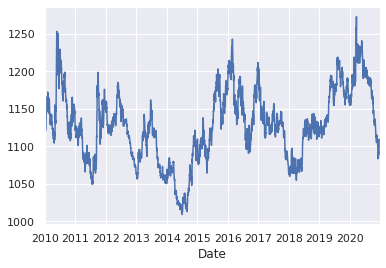

In [25]:
VIX['Close'].plot()


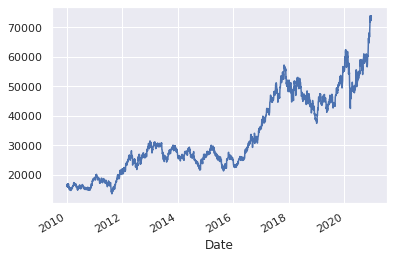

In [26]:
samsung['Close'].plot()

## 수집된 데이터를 기반으로 새로운 데이터 생성
*  

In [28]:
#VIX = VIX.drop(['Open','High','Low', 'Volume','Change'], axis=1) 
VIX = VIX.drop(['Open','High','Low', 'Change'], axis=1) 
# 필요없는거 버리고 close만 쓸거임

In [30]:
VIX.columns = ['VIX_Close']
VIX

,VIX_Close
Date,
2010-01-01,1166.08
2010-01-04,1150.00
2010-01-05,1140.20
2010-01-06,1129.20
2010-01-07,1138.20
...,...
2020-12-17,1093.01
2020-12-18,1099.39
2020-12-21,1102.55


In [31]:
VIX.isnull().sum()

VIX_Close    0
dtype: int64

In [32]:
snv = pd.concat([samsung,VIX],axis=1)
snv

,Open,High,Low,Close,Volume,Change,VIX_Close
Date,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1166.08
2010-01-04,16060.0,16180.0,16000.0,16180.0,239271.0,0.012516,1150.00
2010-01-05,16520.0,16580.0,16300.0,16440.0,559219.0,0.016069,1140.20
2010-01-06,16580.0,16820.0,16520.0,16820.0,459755.0,0.023114,1129.20
2010-01-07,16820.0,16820.0,16260.0,16260.0,443237.0,-0.033294,1138.20
...,...,...,...,...,...,...,...
2020-12-17,73400.0,73700.0,72600.0,73300.0,24293214.0,-0.006775,1093.01
2020-12-18,73300.0,73700.0,73000.0,73000.0,17613029.0,-0.004093,1099.39
2020-12-21,73100.0,73400.0,72000.0,73000.0,20367355.0,0.000000,1102.55


In [33]:
snv.isnull().sum()
# 한국과 미국 영업일이 달라서 합쳤을 때 결측치가 생겨버림..

Open         154
High         154
Low          154
Close        154
Volume       154
Change       154
VIX_Close      0
dtype: int64

In [34]:
snv = snv.dropna()
# 없애버리자

In [35]:
snv.info()
# 건수가 좀 줄었지만 크게 줄지 않았음..

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2710 entries, 2010-01-04 to 2020-12-23
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2710 non-null   float64
 1   High       2710 non-null   float64
 2   Low        2710 non-null   float64
 3   Close      2710 non-null   float64
 4   Volume     2710 non-null   float64
 5   Change     2710 non-null   float64
 6   VIX_Close  2710 non-null   float64
dtypes: float64(7)
memory usage: 169.4 KB


## 머신러닝

In [ ]:
#snv['MA5'] = talib.SMA(snv['Close'], timeperiod=5)
#snv['MA10'] = talib.SMA(snv['Close'], timeperiod=10)
#snv['RASD5'] = talib.SMA(talib.STDDEV(snv['Close'], timeperiod=5, nbdev=1),timeperiod=5)
#snv['RASD10'] = talib.SMA(talib.STDDEV(snv['Close'], timeperiod=5, nbdev=1),timeperiod=10)

In [36]:
def moving_average(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df

In [37]:
snv = moving_average(snv, 10) #10일평균이동선

In [38]:
snv.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Change       0
VIX_Close    0
MA_10        9
dtype: int64

In [39]:
snv = snv.dropna()
# 맨앞 9개 날림

In [40]:
len(snv)

2701

In [41]:
snv['target'] = snv['Close'].pct_change()

In [42]:
snv = snv.dropna()

In [43]:
snv['target'].describe()

count    2700.000000
mean        0.000697
std         0.017284
min        -0.080357
25%        -0.009780
50%         0.000194
75%         0.010327
max         0.104706
Name: target, dtype: float64

In [44]:
snv

,Open,High,Low,Close,Volume,Change,VIX_Close,MA_10,target
Date,,,,,,,,,
2010-01-18,16800.0,16920.0,16560.0,16860.0,261691.0,0.001188,1124.60,16424.0,0.001188
2010-01-19,17000.0,17000.0,16440.0,16460.0,241308.0,-0.023725,1130.30,16426.0,-0.023725
2010-01-20,16460.0,16740.0,16460.0,16680.0,384306.0,0.013366,1144.30,16412.0,0.013366
2010-01-21,16400.0,17000.0,16400.0,17000.0,340148.0,0.019185,1145.00,16486.0,0.019185
2010-01-22,16800.0,16900.0,16360.0,16500.0,470536.0,-0.029412,1154.00,16494.0,-0.029412
...,...,...,...,...,...,...,...,...,...
2020-12-17,73400.0,73700.0,72600.0,73300.0,24293214.0,-0.006775,1093.01,73100.0,-0.006775
2020-12-18,73300.0,73700.0,73000.0,73000.0,17613029.0,-0.004093,1099.39,73250.0,-0.004093
2020-12-21,73100.0,73400.0,72000.0,73000.0,20367355.0,0.000000,1102.55,73260.0,0.000000


In [45]:
snv['target'] = np.where(snv['target'] >= 0 , 1, -1) # 0보다 높거나 같으면 1, 아니면 -1
snv['target'].value_counts()

 1    1452
-1    1248
Name: target, dtype: int64

In [46]:
snv

,Open,High,Low,Close,Volume,Change,VIX_Close,MA_10,target
Date,,,,,,,,,
2010-01-18,16800.0,16920.0,16560.0,16860.0,261691.0,0.001188,1124.60,16424.0,1
2010-01-19,17000.0,17000.0,16440.0,16460.0,241308.0,-0.023725,1130.30,16426.0,-1
2010-01-20,16460.0,16740.0,16460.0,16680.0,384306.0,0.013366,1144.30,16412.0,1
2010-01-21,16400.0,17000.0,16400.0,17000.0,340148.0,0.019185,1145.00,16486.0,1
2010-01-22,16800.0,16900.0,16360.0,16500.0,470536.0,-0.029412,1154.00,16494.0,-1
...,...,...,...,...,...,...,...,...,...
2020-12-17,73400.0,73700.0,72600.0,73300.0,24293214.0,-0.006775,1093.01,73100.0,-1
2020-12-18,73300.0,73700.0,73000.0,73000.0,17613029.0,-0.004093,1099.39,73250.0,-1
2020-12-21,73100.0,73400.0,72000.0,73000.0,20367355.0,0.000000,1102.55,73260.0,1


In [47]:
snv['target'] = snv['target'].shift(-1)

In [48]:
snv = snv.dropna()
#samsung['target'] = samsung['target'].astype(np.int64)
y_var = snv['target']
# 예측에 사용하지 않는 변수 삭제
x_var = snv.drop(['target', 'Open','High','Low', 'Close', 'Volume','Change'], axis=1)
# x값에는 10일 평균이동선과, VIX 지수만 넣어보고 관계를 보자
# y값에는 올랐다, 떨어졌다 즉 1또는 -1

In [49]:
x_var

,VIX_Close,MA_10
Date,,
2010-01-18,1124.60,16424.0
2010-01-19,1130.30,16426.0
2010-01-20,1144.30,16412.0
2010-01-21,1145.00,16486.0
2010-01-22,1154.00,16494.0
...,...,...
2020-12-16,1092.36,72740.0
2020-12-17,1093.01,73100.0
2020-12-18,1099.39,73250.0


## 모델학습

In [50]:
#훈련 세트와 테스트 세트를 나눈다.
#shuffle=False을 설정해 기간이 섞이지 않도록 만든다.
X_train, X_test, y_train, y_test = train_test_split(x_var, 
                                                    y_var, 
                                                    test_size=0.3, 
                                                    shuffle=False, 
                                                    random_state=3)

#훈련 세트와 테스트 세트에 포함된 양성 샘플(up) 비율을 확인한다.
train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts()/train_count)
print('test set label ratio')
print(y_test.value_counts()/test_count)

train set label ratio
 1.0    0.52991
-1.0    0.47009
Name: target, dtype: float64
test set label ratio
 1.0    0.555556
-1.0    0.444444
Name: target, dtype: float64


In [51]:
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print('accuracy:{0:.4f},precision:{1:.4f},recall:{2:.4f},F1:{3:.4f},ROC AUC score:{4:.4f}'.format(accuracy, precision, recall, f1,roc_score))

In [52]:
xgb_dis = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_dis.fit(X_train, y_train)
xgb_pred = xgb_dis.predict(X_test)

In [53]:
xgb_dis

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [54]:
print(xgb_dis.score(X_train, y_train))

0.7930121757543674


In [55]:
get_confusion_matrix(y_test, xgb_pred)

confusion matrix
accuracy:0.4840,precision:0.5465,recall:0.4178,F1:0.4736,ROC AUC score:0.4922


In [56]:
n_estimators = range(10,20,5)

params = {
    'bootstrap': [True],
    'n_estimators':n_estimators,
    'max_depth':[2,3],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 4, 6, 8],
    'max_features':[2]
}

In [57]:
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)

In [58]:
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f436e3b4db0>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_w...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
  

In [59]:
print('best parameter:\n', clf.best_params_)
print('best prediction:{0:.4f}'.format(clf.best_score_))

best parameter:
 {'bootstrap': True, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 15}
best prediction:0.5306


In [60]:
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('accuracy:{0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)

accuracy:0.4926
confusion matrix
accuracy:0.4926,precision:0.5675,recall:0.3644,F1:0.4438,ROC AUC score:0.5086


## 딥러닝 LSTM

In [61]:
samsung_st_date = '2010-12-16'
samsung_enddate = '2020-12-16'
samsung = data.DataReader('005930.ks', 'yahoo', samsung_st_date, samsung_enddate)
samsung.head(9)
#samsung = fdr.DataReader('005930', '2015') #2010년 이후 삼성 주가 가져옴

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-16,18380.0,18160.0,18160.0,18220.0,11684200.0,9.610845
2010-12-17,18580.0,18240.0,18280.0,18520.0,17297200.0,9.769093
2010-12-20,18640.0,18280.0,18340.0,18640.0,16911750.0,9.832390
2010-12-21,18800.0,18500.0,18620.0,18720.0,12599300.0,9.874586
2010-12-22,19060.0,18720.0,18780.0,18780.0,16626800.0,9.906237
2010-12-23,18760.0,18500.0,18720.0,18720.0,10985500.0,9.874586
2010-12-24,18780.0,18500.0,18780.0,18500.0,8471650.0,9.758541
2010-12-27,18600.0,18300.0,18500.0,18440.0,10524200.0,9.726891
2010-12-28,19000.0,18520.0,18560.0,18760.0,15650700.0,9.895689


In [62]:
high_prices = samsung['High'].values
low_prices = samsung['Low'].values
mid_prices = (high_prices + low_prices)/2 # 중간가격

In [63]:
samsung

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-16,18380.0,18160.0,18160.0,18220.0,11684200.0,9.610845
2010-12-17,18580.0,18240.0,18280.0,18520.0,17297200.0,9.769093
2010-12-20,18640.0,18280.0,18340.0,18640.0,16911750.0,9.832390
2010-12-21,18800.0,18500.0,18620.0,18720.0,12599300.0,9.874586
2010-12-22,19060.0,18720.0,18780.0,18780.0,16626800.0,9.906237
...,...,...,...,...,...,...
2020-12-11,73800.0,73100.0,73500.0,73400.0,18486672.0,73400.000000
2020-12-14,74500.0,73200.0,73600.0,73800.0,21510415.0,73800.000000
2020-12-15,74100.0,73300.0,73800.0,73800.0,20863671.0,73800.000000


In [64]:
seq_len = 30
sequence_length = seq_len + 1 
result = []
# 총갯수 - sequence_length를 뺀 만큼만 돌림
for i in range(len(mid_prices) - sequence_length): 
    result.append(mid_prices[i:i+sequence_length]) 

### DATA 정규화

In [65]:
normalized_data = []
for window in result: 
    normalized_window = [((float(p) / float(window[0]))-1)for p in window] 
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

### train, test 분리

In [66]:
row = int(round(result.shape[0]*0.9)) 
train = result[:row,:]        
np.random.shuffle(train)       

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = result[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:,-1]

x_train.shape, x_test.shape

((2186, 30, 1), (243, 30, 1))

In [67]:
x_train[2185] 
# 맨 마지막 결과를 찍어본다.
#x_test[244]



array([[ 0.        ],
       [-0.0036049 ],
       [-0.00793079],
       [-0.01333814],
       [-0.0147801 ],
       [-0.01261716],
       [-0.01225667],
       [-0.02126893],
       [-0.02307138],
       [-0.00648882],
       [ 0.00108147],
       [-0.01658255],
       [-0.03064167],
       [-0.02451334],
       [-0.01405912],
       [-0.01189618],
       [-0.00648882],
       [-0.0075703 ],
       [-0.00576784],
       [-0.00937275],
       [-0.0147801 ],
       [ 0.00576784],
       [ 0.02487383],
       [ 0.02739726],
       [ 0.03100216],
       [ 0.02919971],
       [ 0.03100216],
       [ 0.03208363],
       [ 0.0443403 ],
       [ 0.05263158]])

### window 사이즈에 대한 y값 찍어보기

*  window size 30으로 했을 때, 첫 train 셋의 30일(영업일)치의 x값과, 31일(영업일)차의 y값을 찍어봄

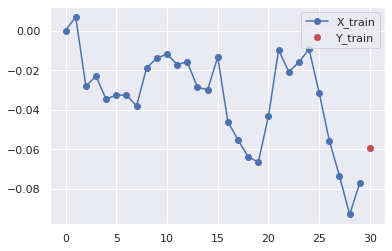

In [71]:
#plt.plot([0, 1, 2,3, 4], x_train[0].flatten(), 'bo-', label="X_train")
plt.plot(range(0,30), x_train[0].flatten(), 'bo-', label="X_train")
plt.plot([30], y_train[0], 'ro', label="Y_train")
plt.legend()


## 딥러닝 모델생성
*  위의 데이터를 가지고 모델 만들기

In [74]:
model = Sequential() 
model.add(LSTM(30, return_sequences=True, input_shape=(30,1))) #30개
model.add(LSTM(64, return_sequences=False))  
model.add(Dense(1, activation='linear')) 
#model.compile(loss='mse', optimizer='rmsprop')
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


### 모델 학습
* EarlyStopping callback을 활용해 val_lose의 개선이 없을경우 학습 조기 종료

In [80]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
training_result = model.fit(x_train, y_train,                 
         validation_data=(x_test, y_test),  
         batch_size=10,                     
         epochs=20)

Epoch 1/20
219/219 [==============================] - 1s 6ms/step - loss: 2.0196e-04 - val_loss: 2.9867e-04
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 2.0641e-04 - val_loss: 2.9917e-04
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 2.0662e-04 - val_loss: 2.9628e-04
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 2.0065e-04 - val_loss: 3.1983e-04
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 2.1311e-04 - val_loss: 3.2559e-04
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 2.1075e-04 - val_loss: 3.1886e-04
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 2.0093e-04 - val_loss: 2.9666e-04
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 2.0392e-04 - val_loss: 3.1267e-04
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 2.0483e-04 - val_loss: 3.0626e-04
Epoch 10/20
219/219 [=======

### 학습된 모델로 예측한 주식 결과 출력
* 예측

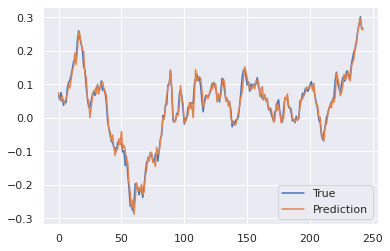

In [81]:
pred = model.predict(x_test) 
fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

### 학습 과정 출력
*  loss와 val_loss 지표로 과적합 유무 판단하기

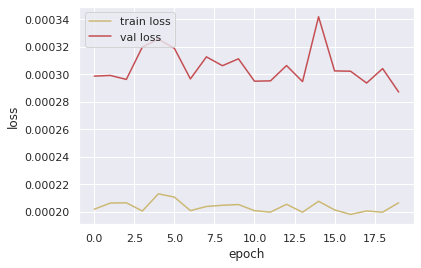

In [82]:
plt.plot(training_result.history['loss'], 'y', label='train loss')
plt.plot(training_result.history['val_loss'], 'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')

plt.show()

### Model 저장/불러오기 기능


In [83]:
model.save('model.h5')
from keras.models import load_model
model_2 = load_model('model.h5')

* 저장한 모델을 불러와 x_test 적용

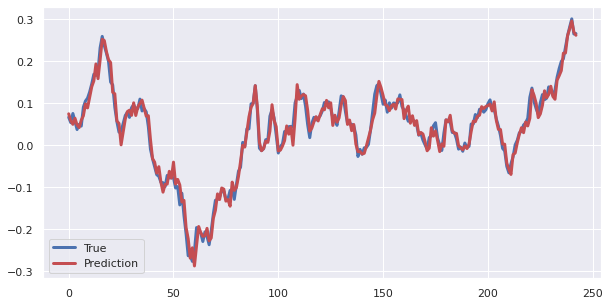

In [84]:
pred = model_2.predict(x_test)

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True 

plt.plot(y_test, color='b', label='True')
plt.plot(pred, color='r', label='Prediction')
plt.legend()
plt.show()